In [81]:
from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.utils import laplacian_matrix
from src.torch_erg.samplers import GWGSampler, MHSampler
import torch
import numpy as np
import networkx as nx
import random as rnd

from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
# parsing the .m file into a suitable format, and perform some sanity checks
import matplotlib.pyplot as plt

from plots import *
from graph_generators import *
from param_estimation import *
from other_g_stats import *

In [2]:
name = '30_ieee'
SOFT_CONN = True

ordmat, ordlist, buslist, countlist = lp.pow_parser(name)

ordmat = torch.tensor(ordmat)
ordlist = torch.tensor(ordlist)
buslist = torch.tensor(buslist)
countlist = torch.tensor(countlist)

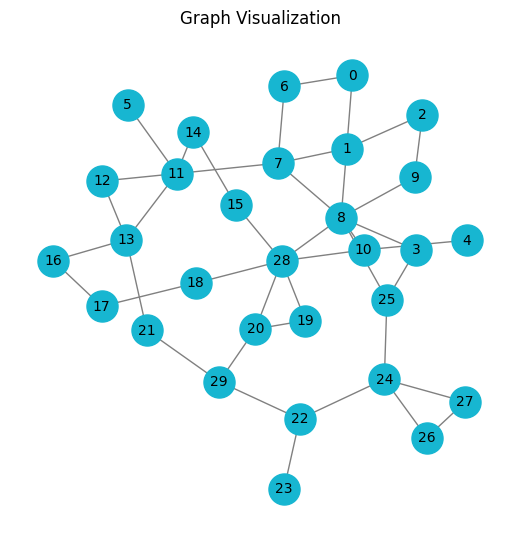

In [17]:
plot_graph(ordmat, labels=True)

## Paramteri comuni

In [ ]:
alpha = 0.001
niter = 200000
min_change = 0.05
update_steps = 3

niter_sampling = 100000


## MH con 5 osservabili

In [23]:
class MySamplerFiveStats(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        L = laplacian_matrix(mtx)
        a3 = torch.matmul(torch.matmul(mtx,mtx),mtx)

        edges = torch.sum(mtx)/2
        triangles = torch.trace(a3)/6
        ac = torch.linalg.eigvalsh(L)[1]
        deg = torch.diagonal(L)
        tri_diag = torch.diagonal(a3) / 2

        valid = deg > 1
        local_clust = torch.zeros_like(deg)
        local_clust[valid] = tri_diag[valid] / (deg[valid] * (deg[valid] - 1))
        avg_clustering = torch.mean(local_clust[valid])

        avg_degree = torch.sum(mtx, dim=1).mean()

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))

betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)


sampler_five_stats = MySamplerFiveStats(backend="cuda")

obs_five_stats = sampler_five_stats.observables(ordmat)

params_five_stats, graphs_five_stats = sampler_five_stats.param_run(graph=ordmat,
                      observables=obs_five_stats,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


  0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 200000/200000 [04:22<00:00, 763.09it/s] 

number of accepted steps is:  46464
number of rejected samples:  153536
number of effective updates is:  15488


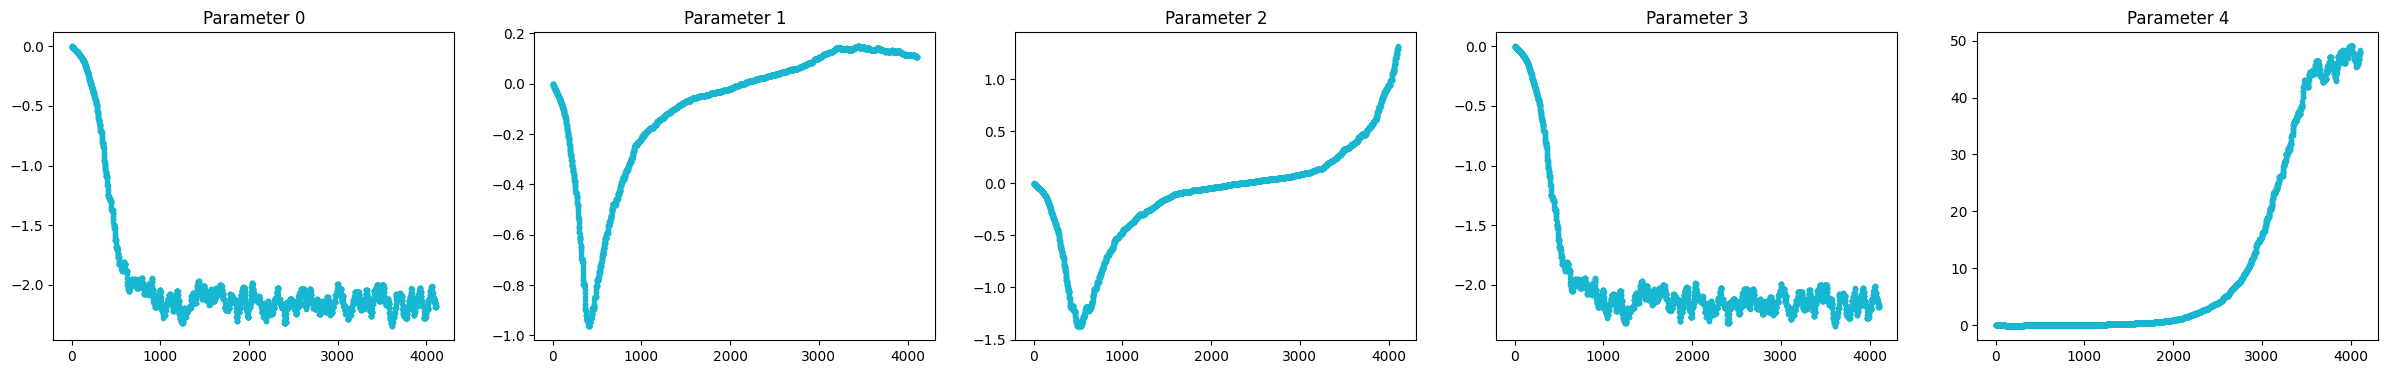

In [24]:
plot_params_iterations(params_five_stats)

In [25]:

params_for_estimates = torch.stack(params_five_stats[-100:]).mean(axis = 0)

observables_five_stats, graphs_five_stats = sampler_five_stats.sample_run(graph=ordmat,
                      observables=obs_five_stats,
                      params=params_for_estimates,
                      niter=niter_sampling,
                      save_every=50)

100%|██████████| 100000/100000 [02:11<00:00, 759.13it/s]

number of accepted steps is:  20403
number of rejected samples:  79597
Mean obs:  tensor([44.6795,  8.1724,  0.0674,  2.9786,  0.1231], dtype=torch.float64)


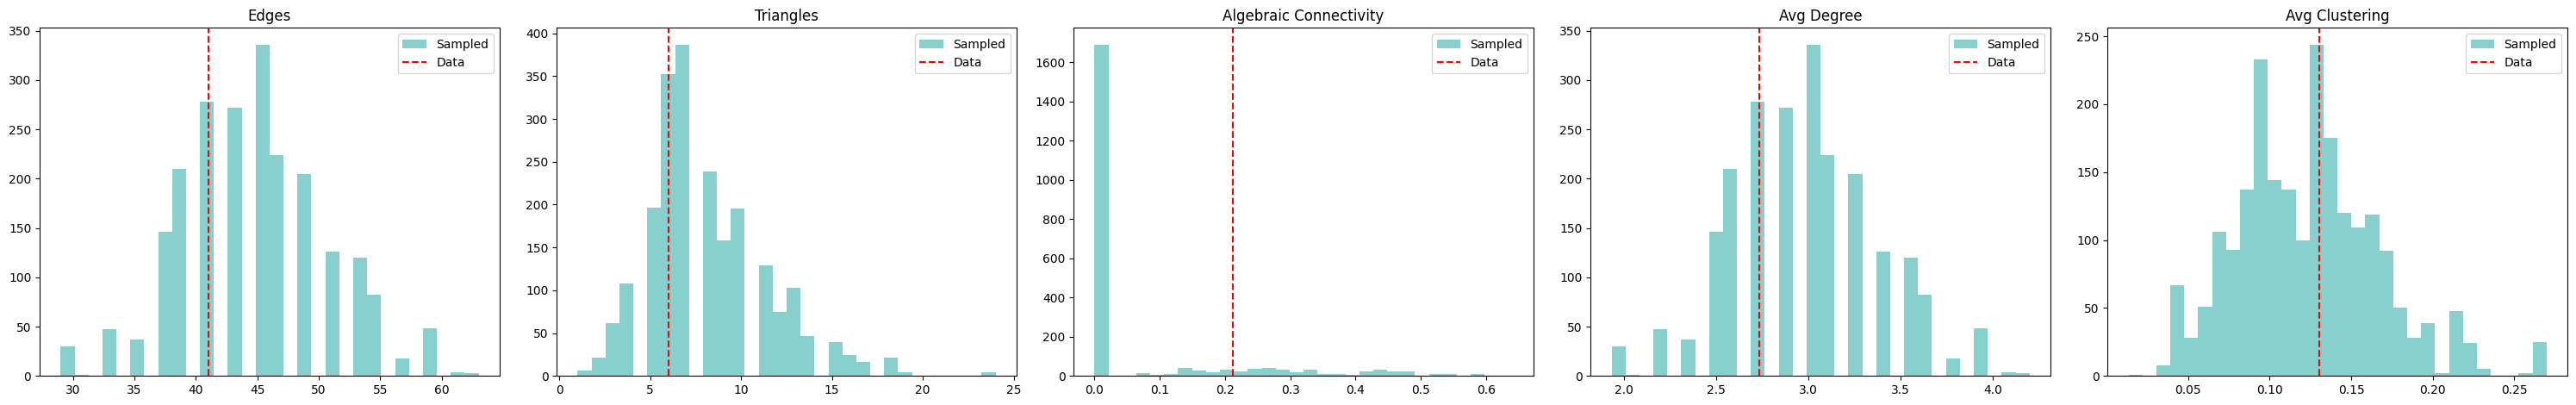

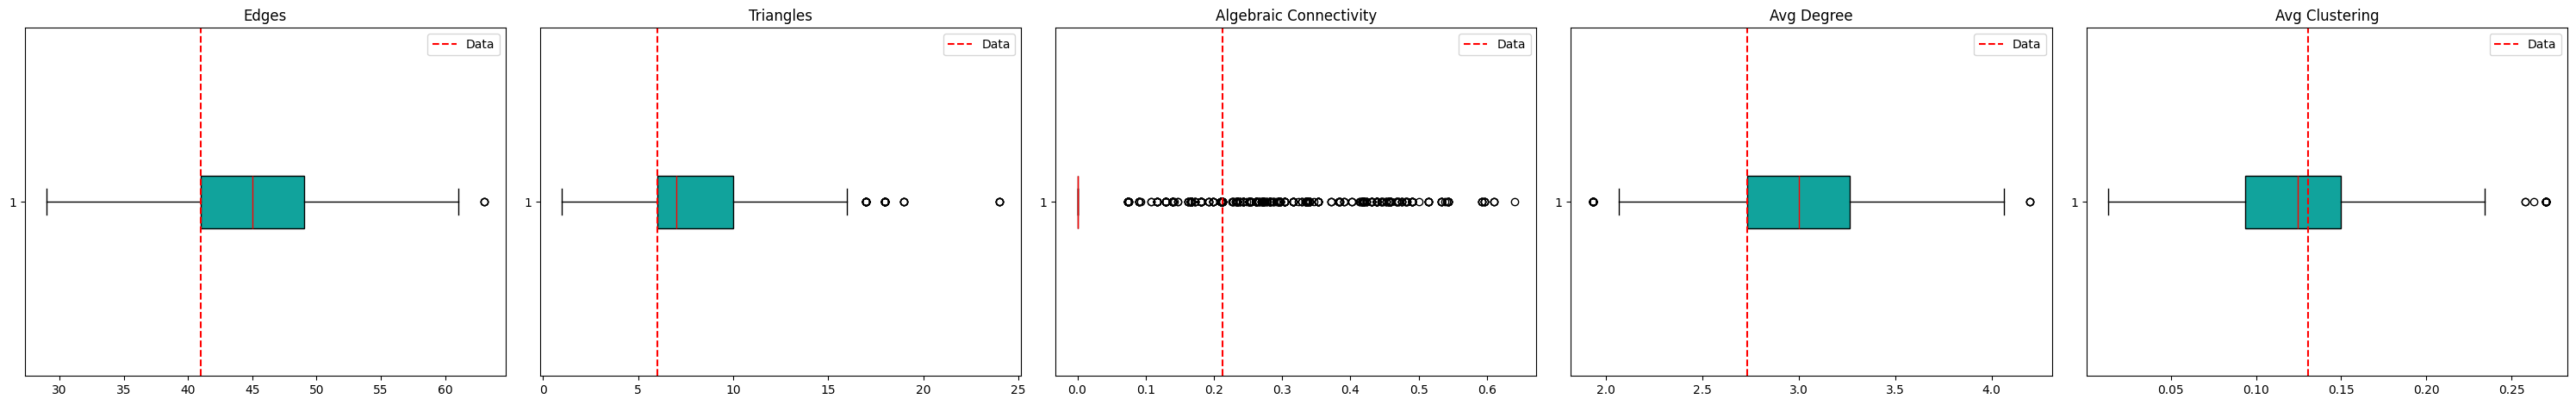

In [26]:
hist_obs_samples(observables_five_stats, obs_five_stats, obs_labels = ['Edges', 'Triangles', 'Algebraic Connectivity', 'Avg Degree', 'Avg Clustering'])
boxplot_obs_samples(observables_five_stats, obs_five_stats, obs_labels = ['Edges', 'Triangles', 'Algebraic Connectivity', 'Avg Degree', 'Avg Clustering'])

In [27]:
connected_graphs_five_stats = [g for g in graphs_five_stats if connected_components(csr_matrix(g.cpu().numpy()))[0] <= 2]
connected_observables_five_stats = [sampler_five_stats.observables(g) for g in connected_graphs_five_stats]
len(connected_graphs_five_stats)

1077

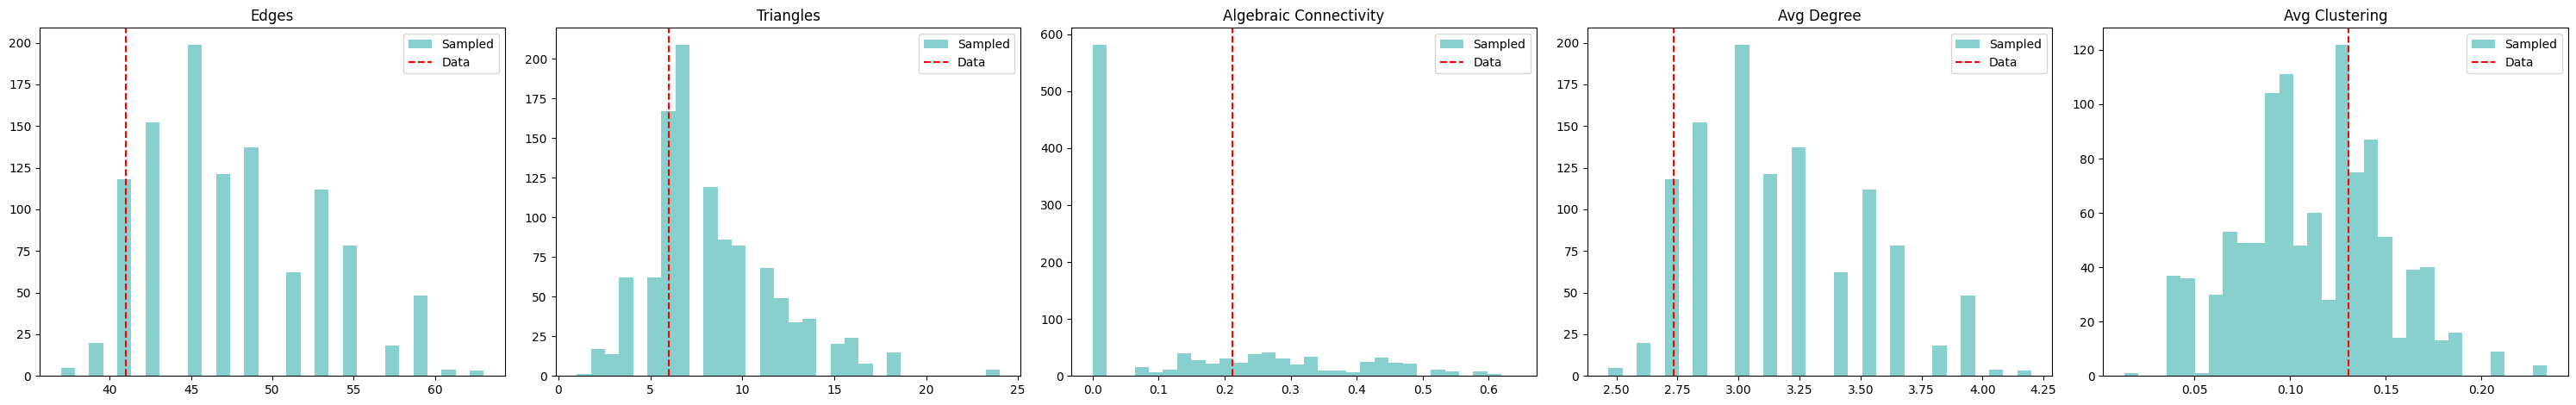

In [28]:
hist_obs_samples(connected_observables_five_stats, obs_five_stats, obs_labels = ['Edges', 'Triangles', 'Algebraic Connectivity', 'Avg Degree', 'Avg Clustering'])

In [29]:
class MySamplerNoAC(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)
    def observables(self,mtx):
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, avg_degree, avg_clustering]))
    
betas = torch.tensor([0., 0., 0., 0.], dtype=float)
sampler_no_ac = MySamplerNoAC(backend="cuda")
obs_no_ac = sampler_no_ac.observables(ordmat)
params_no_ac, graphs_no_ac = sampler_no_ac.param_run(graph=ordmat,
                      observables=obs_no_ac,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


100%|██████████| 200000/200000 [03:16<00:00, 1018.77it/s]

number of accepted steps is:  46144
number of rejected samples:  153856
number of effective updates is:  15381


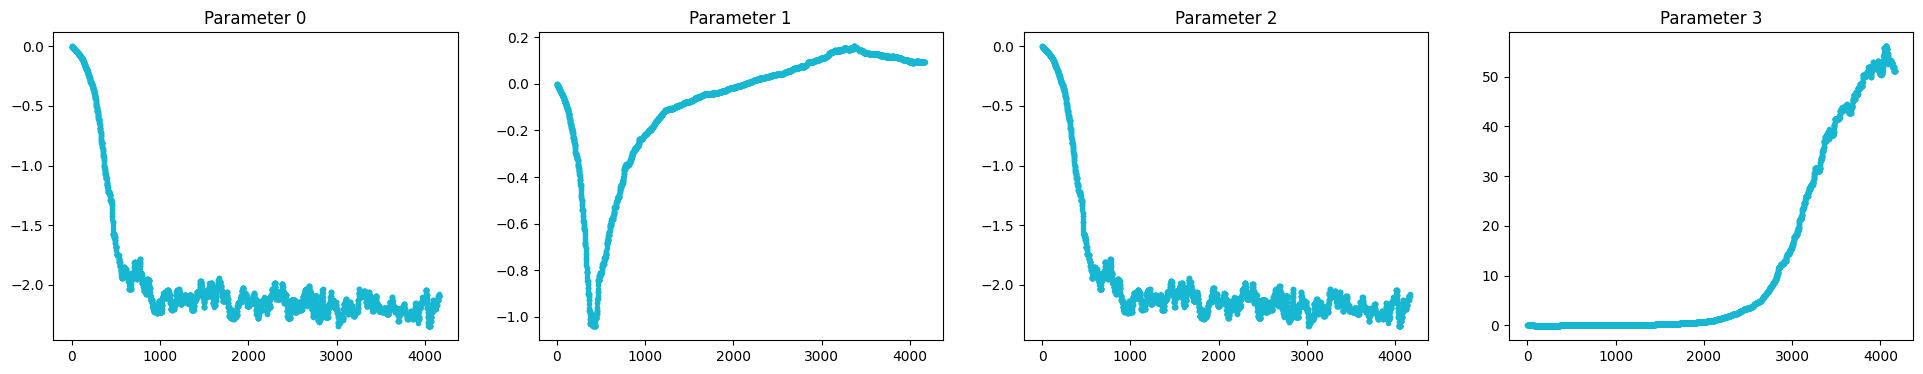

In [30]:
plot_params_iterations(params_no_ac)

In [31]:
params_for_estimates = torch.stack(params_no_ac[-100:]).mean(axis = 0)
# run in sample mode, without parameter modifications
observables_no_ac, graphs_no_ac = sampler_no_ac.sample_run(graph=ordmat,
                      observables=obs_no_ac,
                      params=params_for_estimates,
                      niter=niter_sampling,
                      save_every=50)

100%|██████████| 100000/100000 [01:32<00:00, 1075.91it/s]

number of accepted steps is:  16942
number of rejected samples:  83058
Mean obs:  tensor([36.6652,  6.3457,  2.4443,  0.1587], dtype=torch.float64)


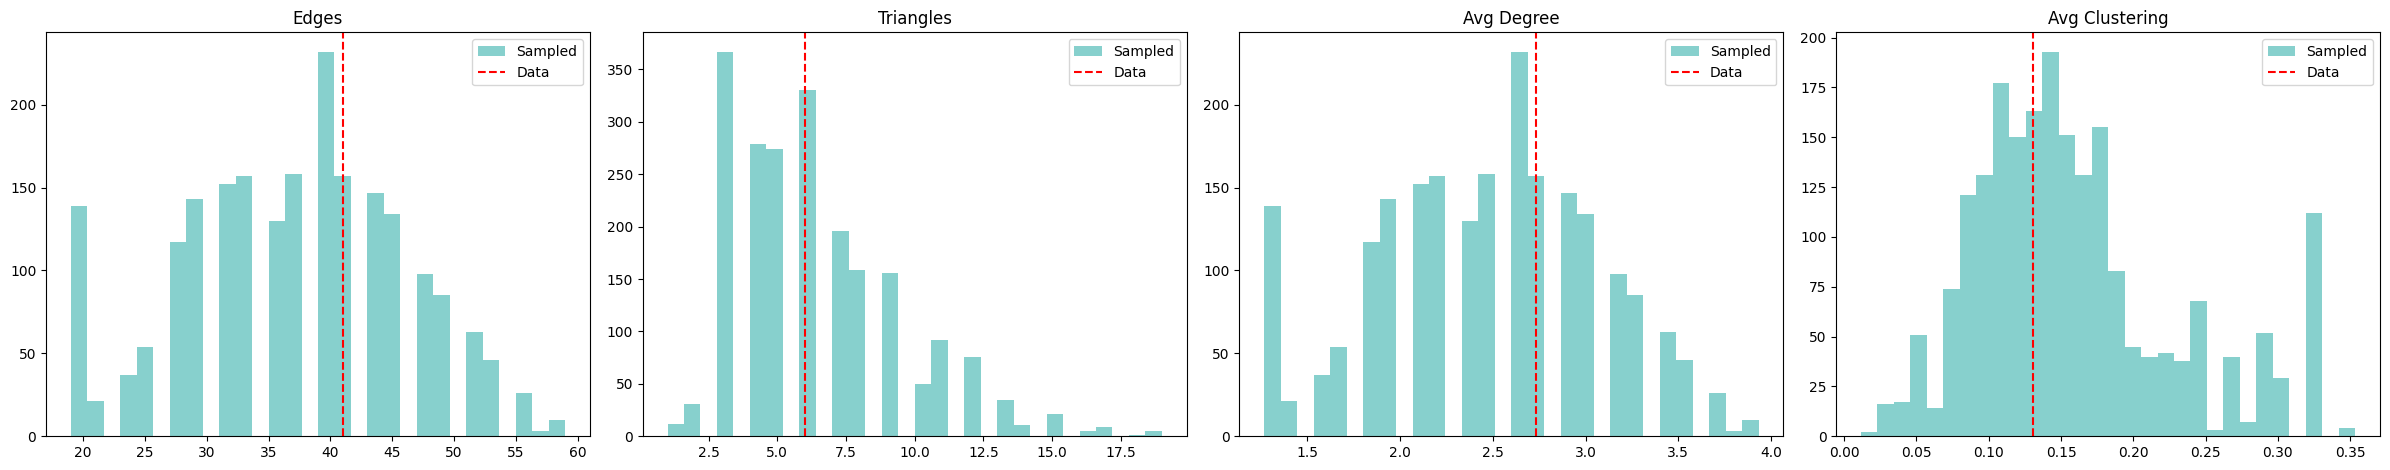

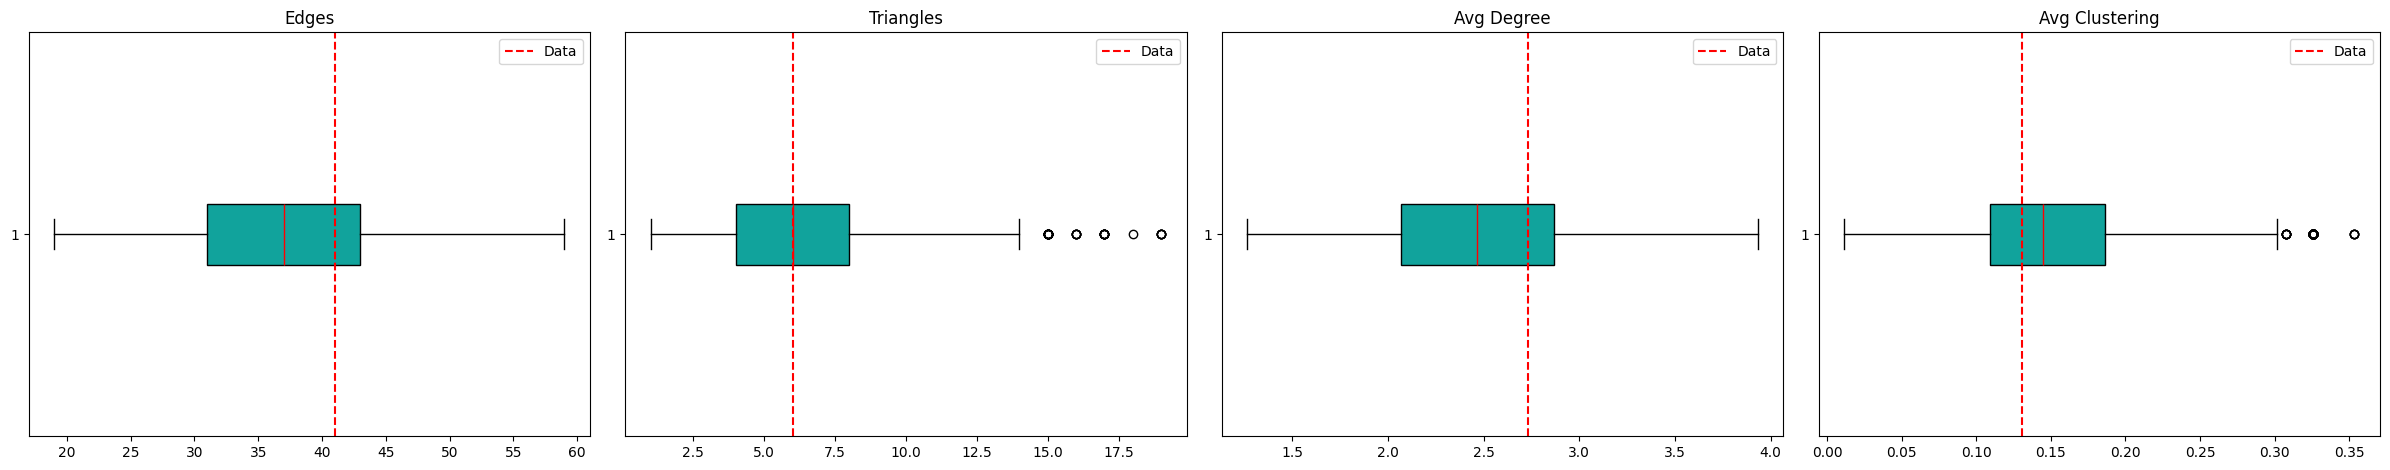

In [32]:
hist_obs_samples(observables_no_ac, obs_no_ac, obs_labels = ['Edges', 'Triangles', 'Avg Degree', 'Avg Clustering'])
boxplot_obs_samples(observables_no_ac, obs_no_ac, obs_labels = ['Edges', 'Triangles', 'Avg Degree', 'Avg Clustering'])

In [33]:
connected_graphs_no_ac = [g for g in graphs_no_ac if connected_components(csr_matrix(g.cpu().numpy()))[0] <= 2]
connected_observables_no_ac = [sampler_no_ac.observables(g) for g in connected_graphs_no_ac]
len(connected_graphs_no_ac)

457

---

## Gibbs Sampling

In [34]:
class GWGSampler(GWGSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        
        L = laplacian_matrix(mtx)
        a3 = torch.matmul(torch.matmul(mtx,mtx),mtx)

        edges = torch.sum(mtx)/2
        triangles = torch.trace(a3)/6
        ac = torch.linalg.eigvalsh(L)[1]
        deg = torch.diagonal(L)
        tri_diag = torch.diagonal(a3) / 2

        valid = deg > 1
        local_clust = torch.zeros_like(deg)
        local_clust[valid] = tri_diag[valid] / (deg[valid] * (deg[valid] - 1))
        avg_clustering = torch.mean(local_clust[valid])

        avg_degree = torch.sum(mtx, dim=1).mean()

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))


betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)

samplerGWG = GWGSampler(backend="cpu")
obsGWG = samplerGWG.observables(ordmat)

paramsGWG, _ = samplerGWG.param_run(graph=ordmat,
                      observables=obsGWG,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

100%|██████████| 200000/200000 [11:33<00:00, 288.34it/s]

number of accepted steps is:  71809
number of rejected samples:  128191
number of effective updates is:  23936


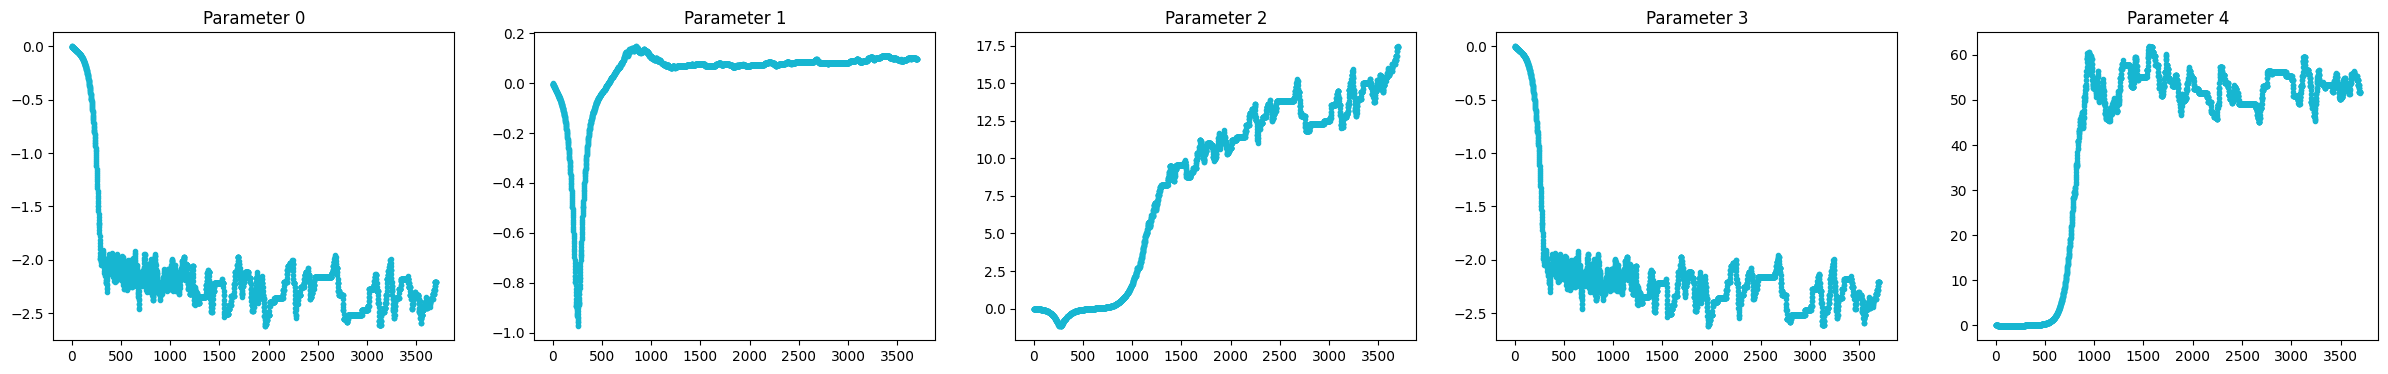

In [35]:
plot_params_iterations(paramsGWG)

In [36]:
params_for_estimates = torch.stack(paramsGWG[-100:]).mean(axis = 0)
# run in sample mode, without parameter modifications
observablesGWG, graphsGWG = samplerGWG.sample_run(graph=ordmat,
                      observables=obsGWG,
                      params=params_for_estimates,
                      niter=niter_sampling,
                      save_every=50)

100%|██████████| 100000/100000 [02:14<00:00, 741.32it/s]

number of accepted steps is:  2820
number of rejected samples:  97180
Mean obs:  tensor([2.0872e+01, 3.2247e+00, 8.7453e-03, 1.3914e+00, 3.0976e-01],
       dtype=torch.float64)


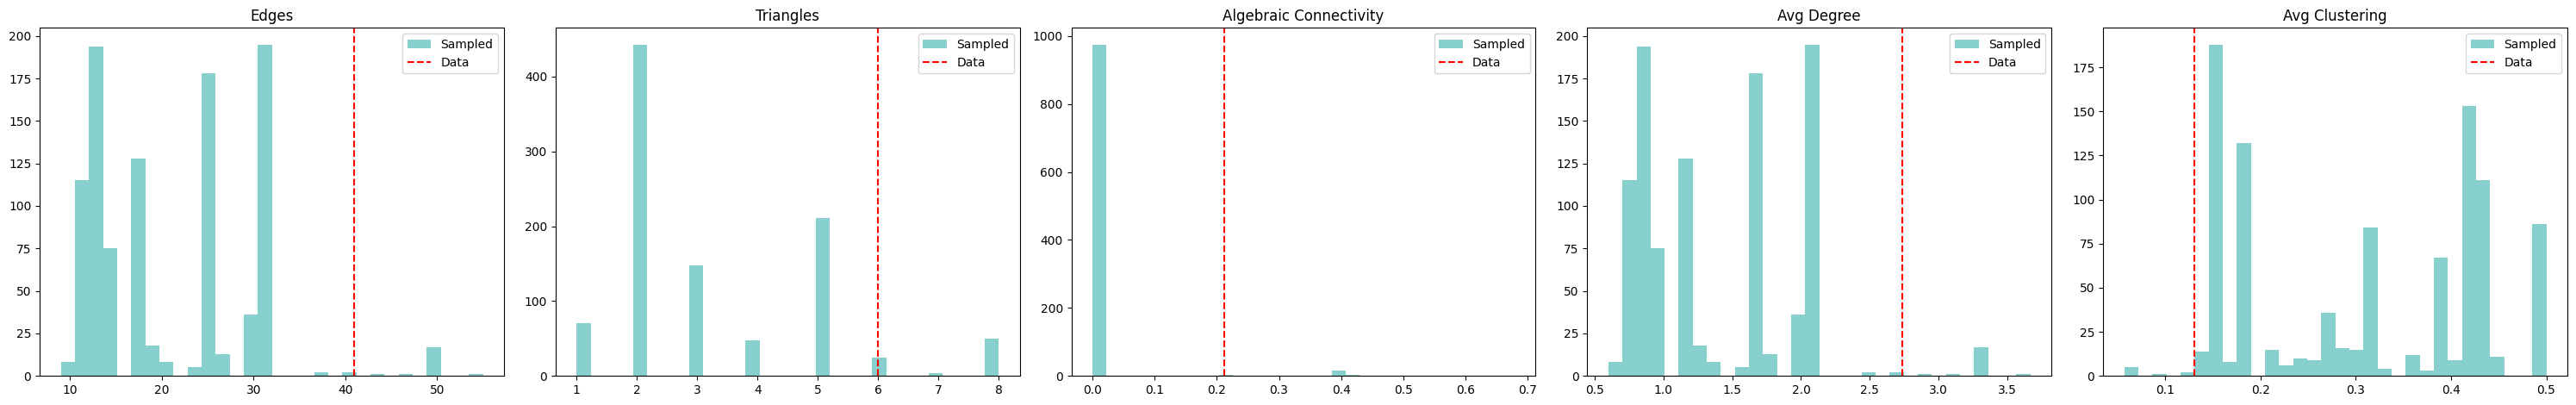

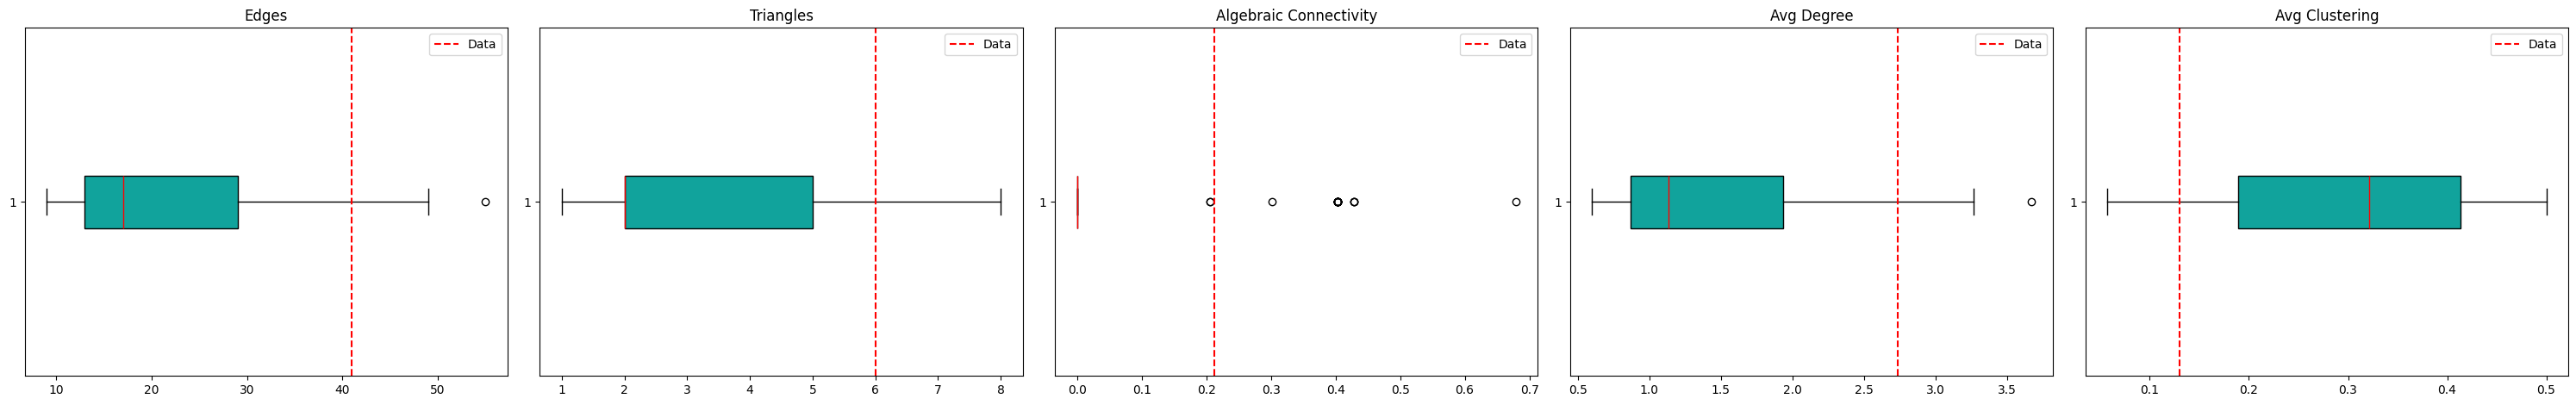

In [37]:
hist_obs_samples(observablesGWG, obsGWG, obs_labels = ['Edges', 'Triangles', 'Algebraic Connectivity', 'Avg Degree', 'Avg Clustering'])
boxplot_obs_samples(observablesGWG, obsGWG, obs_labels = ['Edges', 'Triangles', 'Algebraic Connectivity', 'Avg Degree', 'Avg Clustering'])

In [38]:
connected_graphs_gibbs_five = [g for g in graphsGWG if connected_components(csr_matrix(g.cpu().numpy()))[0] <= 2]
connected_observables_gibbs_five = [samplerGWG.observables(g) for g in connected_graphs_gibbs_five]
len(connected_graphs_gibbs_five)

22

---

In [39]:
print(abs(obs_five_stats.cpu() - torch.stack(observables_five_stats).mean(axis = 0).cpu()))
print(abs(obs_no_ac.cpu() -torch.stack(observables_no_ac).mean(axis = 0).cpu()))
print(abs(obs_five_stats.cpu() - torch.stack(observablesGWG).mean(axis = 0).cpu()))

tensor([3.6795, 2.1724, 0.1447, 0.2453, 0.0074], dtype=torch.float64)
tensor([4.3348, 0.3457, 0.2890, 0.0283], dtype=torch.float64)
tensor([20.1284,  2.7753,  0.2034,  1.3419,  0.1793], dtype=torch.float64)


---

In [41]:
class MyGWGSampler(GWGSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        L = laplacian_matrix(mtx)
        a3 = torch.matmul(torch.matmul(mtx,mtx),mtx)

        edges = torch.sum(mtx)/2
        triangles = torch.trace(a3)/6
        ac = torch.linalg.eigvalsh(L)[1]
        deg = torch.diagonal(L)
        tri_diag = torch.diagonal(a3) / 2

        valid = deg > 1
        local_clust = torch.zeros_like(deg)
        local_clust[valid] = tri_diag[valid] / (deg[valid] * (deg[valid] - 1))
        avg_clustering = torch.mean(local_clust[valid])

        avg_degree = torch.sum(mtx, dim=1).mean()

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))


betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)
sampler_for_runs = MyGWGSampler(backend="cuda")
tmp = sampler_for_runs.observables(ordmat)
mean, std, all_means, all_param_sets = get_stats_from_sampler(input_graph = ordmat, sampler = sampler_for_runs, n_iter_training = 100000, n_iter_sampling = 100000, n_processes= 30, init_betas= betas)

CUDA backend not available falling back to cpu


100%|██████████| 100000/100000 [03:49<00:00, 436.55it/s]


number of accepted steps is:  61112
number of rejected samples:  38888
number of effective updates is:  20370


100%|██████████| 100000/100000 [02:34<00:00, 645.97it/s]


number of accepted steps is:  22323
number of rejected samples:  77677
Mean obs:  tensor([39.8584,  6.8283,  0.2367,  2.6572,  0.1886], dtype=torch.float64)


100%|██████████| 100000/100000 [03:23<00:00, 492.20it/s]


number of accepted steps is:  61008
number of rejected samples:  38992
number of effective updates is:  20336


100%|██████████| 100000/100000 [02:30<00:00, 663.02it/s]


number of accepted steps is:  39695
number of rejected samples:  60305
Mean obs:  tensor([56.1568, 10.8927,  0.5699,  3.7438,  0.1008], dtype=torch.float64)


100%|██████████| 100000/100000 [03:11<00:00, 520.89it/s]


number of accepted steps is:  62763
number of rejected samples:  37237
number of effective updates is:  20921


100%|██████████| 100000/100000 [02:37<00:00, 634.67it/s]


number of accepted steps is:  28321
number of rejected samples:  71679
Mean obs:  tensor([48.1004,  7.6795,  0.3552,  3.2067,  0.1024], dtype=torch.float64)


100%|██████████| 100000/100000 [03:17<00:00, 505.33it/s]


number of accepted steps is:  60188
number of rejected samples:  39812
number of effective updates is:  20062


100%|██████████| 100000/100000 [02:18<00:00, 723.86it/s]


number of accepted steps is:  10195
number of rejected samples:  89805
Mean obs:  tensor([13.3895,  1.9850,  0.0204,  0.8926,  0.4349], dtype=torch.float64)


100%|██████████| 100000/100000 [03:36<00:00, 461.96it/s]


number of accepted steps is:  61587
number of rejected samples:  38413
number of effective updates is:  20529


100%|██████████| 100000/100000 [02:33<00:00, 649.51it/s]


number of accepted steps is:  23906
number of rejected samples:  76094
Mean obs:  tensor([36.1473,  6.0540,  0.1391,  2.4098,  0.1719], dtype=torch.float64)


100%|██████████| 100000/100000 [03:41<00:00, 451.63it/s]


number of accepted steps is:  62342
number of rejected samples:  37658
number of effective updates is:  20780


100%|██████████| 100000/100000 [02:27<00:00, 676.72it/s]


number of accepted steps is:  15409
number of rejected samples:  84591
Mean obs:  tensor([32.4143,  5.3478,  0.0929,  2.1610,  0.2076], dtype=torch.float64)


100%|██████████| 100000/100000 [03:36<00:00, 461.99it/s]


number of accepted steps is:  63804
number of rejected samples:  36196
number of effective updates is:  21268


100%|██████████| 100000/100000 [02:40<00:00, 622.40it/s]


number of accepted steps is:  40932
number of rejected samples:  59068
Mean obs:  tensor([51.3771,  9.1460,  0.4498,  3.4251,  0.1027], dtype=torch.float64)


100%|██████████| 100000/100000 [03:29<00:00, 477.81it/s]


number of accepted steps is:  61845
number of rejected samples:  38155
number of effective updates is:  20615


100%|██████████| 100000/100000 [02:42<00:00, 615.96it/s]


number of accepted steps is:  33551
number of rejected samples:  66449
Mean obs:  tensor([60.8084, 13.3371,  0.7535,  4.0539,  0.0992], dtype=torch.float64)


100%|██████████| 100000/100000 [03:31<00:00, 472.74it/s]


number of accepted steps is:  61301
number of rejected samples:  38699
number of effective updates is:  20433


100%|██████████| 100000/100000 [02:51<00:00, 582.55it/s]


number of accepted steps is:  41798
number of rejected samples:  58202
Mean obs:  tensor([61.7754, 13.9453,  0.7563,  4.1184,  0.1008], dtype=torch.float64)


100%|██████████| 100000/100000 [03:36<00:00, 461.85it/s]


number of accepted steps is:  61715
number of rejected samples:  38285
number of effective updates is:  20571


100%|██████████| 100000/100000 [01:55<00:00, 862.45it/s]


number of accepted steps is:  11054
number of rejected samples:  88946
Mean obs:  tensor([26.8145,  4.9561,  0.0399,  1.7876,  0.2924], dtype=torch.float64)


100%|██████████| 100000/100000 [02:50<00:00, 586.61it/s]


number of accepted steps is:  62144
number of rejected samples:  37856
number of effective updates is:  20714


100%|██████████| 100000/100000 [01:59<00:00, 840.22it/s]


number of accepted steps is:  13188
number of rejected samples:  86812
Mean obs:  tensor([25.5682,  3.8089,  0.0783,  1.7045,  0.3194], dtype=torch.float64)


100%|██████████| 100000/100000 [03:17<00:00, 507.33it/s]


number of accepted steps is:  61405
number of rejected samples:  38595
number of effective updates is:  20468


100%|██████████| 100000/100000 [02:22<00:00, 701.72it/s]


number of accepted steps is:  34265
number of rejected samples:  65735
Mean obs:  tensor([68.7222, 16.7501,  1.0744,  4.5815,  0.0938], dtype=torch.float64)


100%|██████████| 100000/100000 [03:42<00:00, 449.48it/s]


number of accepted steps is:  63269
number of rejected samples:  36731
number of effective updates is:  21089


100%|██████████| 100000/100000 [02:16<00:00, 734.09it/s]


number of accepted steps is:  9193
number of rejected samples:  90807
Mean obs:  tensor([1.3370e+01, 1.9800e+00, 8.1650e-03, 8.9132e-01, 4.4622e-01],
       dtype=torch.float64)


100%|██████████| 100000/100000 [03:42<00:00, 448.90it/s]


number of accepted steps is:  62827
number of rejected samples:  37173
number of effective updates is:  20942


100%|██████████| 100000/100000 [02:31<00:00, 661.20it/s]


number of accepted steps is:  14335
number of rejected samples:  85665
Mean obs:  tensor([36.3116,  6.5267,  0.1119,  2.4208,  0.2104], dtype=torch.float64)


100%|██████████| 100000/100000 [03:48<00:00, 437.95it/s]


number of accepted steps is:  62467
number of rejected samples:  37533
number of effective updates is:  20822


100%|██████████| 100000/100000 [02:39<00:00, 625.98it/s]


number of accepted steps is:  22732
number of rejected samples:  77268
Mean obs:  tensor([41.7214,  6.5429,  0.1703,  2.7814,  0.1357], dtype=torch.float64)


100%|██████████| 100000/100000 [03:44<00:00, 445.56it/s]


number of accepted steps is:  61404
number of rejected samples:  38596
number of effective updates is:  20468


100%|██████████| 100000/100000 [02:12<00:00, 757.02it/s]


number of accepted steps is:  2873
number of rejected samples:  97127
Mean obs:  tensor([ 1.2148e+01,  1.5594e+00, -9.4371e-17,  8.0988e-01,  4.7074e-01],
       dtype=torch.float64)


100%|██████████| 100000/100000 [03:43<00:00, 447.66it/s]


number of accepted steps is:  62668
number of rejected samples:  37332
number of effective updates is:  20889


100%|██████████| 100000/100000 [02:24<00:00, 691.23it/s]


number of accepted steps is:  13075
number of rejected samples:  86925
Mean obs:  tensor([22.6751,  3.6035,  0.0455,  1.5117,  0.3284], dtype=torch.float64)


100%|██████████| 100000/100000 [03:49<00:00, 435.63it/s]


number of accepted steps is:  61892
number of rejected samples:  38108
number of effective updates is:  20630


100%|██████████| 100000/100000 [02:19<00:00, 715.81it/s]


number of accepted steps is:  6246
number of rejected samples:  93754
Mean obs:  tensor([1.9471e+01, 3.1432e+00, 4.2011e-04, 1.2981e+00, 3.7019e-01],
       dtype=torch.float64)


100%|██████████| 100000/100000 [03:45<00:00, 442.54it/s]


number of accepted steps is:  61900
number of rejected samples:  38100
number of effective updates is:  20633


100%|██████████| 100000/100000 [02:40<00:00, 624.18it/s]


number of accepted steps is:  28292
number of rejected samples:  71708
Mean obs:  tensor([59.2991, 12.1337,  0.7445,  3.9533,  0.1001], dtype=torch.float64)


100%|██████████| 100000/100000 [03:46<00:00, 442.29it/s]


number of accepted steps is:  60312
number of rejected samples:  39688
number of effective updates is:  20104


100%|██████████| 100000/100000 [02:48<00:00, 594.69it/s]


number of accepted steps is:  35376
number of rejected samples:  64624
Mean obs:  tensor([65.6609, 15.7495,  0.9584,  4.3774,  0.0988], dtype=torch.float64)


100%|██████████| 100000/100000 [03:46<00:00, 441.65it/s]


number of accepted steps is:  60905
number of rejected samples:  39095
number of effective updates is:  20301


100%|██████████| 100000/100000 [02:43<00:00, 610.64it/s]


number of accepted steps is:  28882
number of rejected samples:  71118
Mean obs:  tensor([42.9851,  8.1064,  0.2103,  2.8657,  0.1519], dtype=torch.float64)


100%|██████████| 100000/100000 [03:44<00:00, 444.48it/s]


number of accepted steps is:  60262
number of rejected samples:  39738
number of effective updates is:  20087


100%|██████████| 100000/100000 [02:52<00:00, 581.30it/s]


number of accepted steps is:  42821
number of rejected samples:  57179
Mean obs:  tensor([74.3942, 22.0358,  1.2644,  4.9596,  0.1049], dtype=torch.float64)


100%|██████████| 100000/100000 [03:54<00:00, 426.83it/s]


number of accepted steps is:  62277
number of rejected samples:  37723
number of effective updates is:  20759


100%|██████████| 100000/100000 [02:18<00:00, 720.52it/s]


number of accepted steps is:  14539
number of rejected samples:  85461
Mean obs:  tensor([19.0870,  2.6610,  0.0466,  1.2725,  0.3947], dtype=torch.float64)


100%|██████████| 100000/100000 [03:34<00:00, 466.82it/s]


number of accepted steps is:  63263
number of rejected samples:  36737
number of effective updates is:  21087


100%|██████████| 100000/100000 [02:12<00:00, 753.44it/s]


number of accepted steps is:  8265
number of rejected samples:  91735
Mean obs:  tensor([2.0687e+01, 3.1874e+00, 7.1082e-03, 1.3791e+00, 3.3204e-01],
       dtype=torch.float64)


100%|██████████| 100000/100000 [03:35<00:00, 463.72it/s]


number of accepted steps is:  61268
number of rejected samples:  38732
number of effective updates is:  20422


100%|██████████| 100000/100000 [02:12<00:00, 756.20it/s]


number of accepted steps is:  9666
number of rejected samples:  90334
Mean obs:  tensor([23.0919,  3.8379,  0.1182,  1.5395,  0.3614], dtype=torch.float64)


100%|██████████| 100000/100000 [03:32<00:00, 471.33it/s]


number of accepted steps is:  61954
number of rejected samples:  38046
number of effective updates is:  20651


100%|██████████| 100000/100000 [02:33<00:00, 651.59it/s]


number of accepted steps is:  28343
number of rejected samples:  71657
Mean obs:  tensor([46.5469,  7.7100,  0.3182,  3.1031,  0.1243], dtype=torch.float64)


100%|██████████| 100000/100000 [03:33<00:00, 467.43it/s]


number of accepted steps is:  58280
number of rejected samples:  41720
number of effective updates is:  19426


100%|██████████| 100000/100000 [02:46<00:00, 601.95it/s]


number of accepted steps is:  43312
number of rejected samples:  56688
Mean obs:  tensor([77.6677, 24.3484,  1.4319,  5.1778,  0.1040], dtype=torch.float64)


100%|██████████| 100000/100000 [03:40<00:00, 452.79it/s]


number of accepted steps is:  63315
number of rejected samples:  36685
number of effective updates is:  21105


100%|██████████| 100000/100000 [02:17<00:00, 728.86it/s]


number of accepted steps is:  9149
number of rejected samples:  90851
Mean obs:  tensor([19.7850,  3.1151,  0.0340,  1.3190,  0.3579], dtype=torch.float64)


100%|██████████| 100000/100000 [03:40<00:00, 453.92it/s]


number of accepted steps is:  62077
number of rejected samples:  37923
number of effective updates is:  20692


100%|██████████| 100000/100000 [02:07<00:00, 786.65it/s]


number of accepted steps is:  2988
number of rejected samples:  97012
Mean obs:  tensor([ 1.0158e+01,  1.2559e+00, -5.8097e-17,  6.7723e-01,  4.9388e-01],
       dtype=torch.float64)


100%|██████████| 100000/100000 [03:36<00:00, 460.89it/s]


number of accepted steps is:  60320
number of rejected samples:  39680
number of effective updates is:  20106


100%|██████████| 100000/100000 [02:41<00:00, 618.56it/s]

number of accepted steps is:  36458
number of rejected samples:  63542
Mean obs:  tensor([55.1092,  9.9607,  0.5593,  3.6739,  0.0943], dtype=torch.float64)


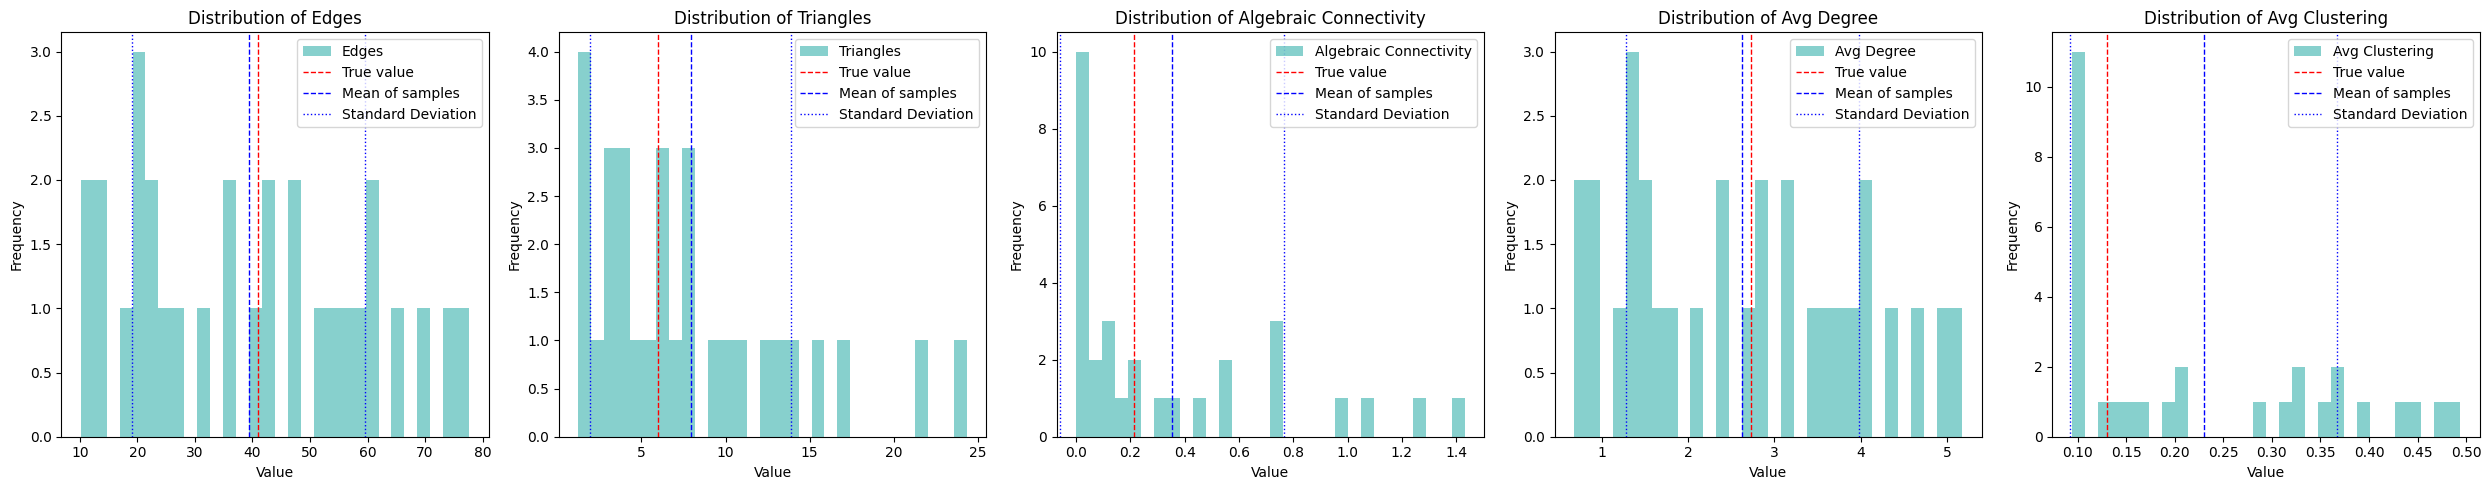

In [53]:
plot_stats_on_samples(true_vals=sampler_for_runs.observables(ordmat), 
                      mean_samplers=torch.stack(all_means), 
                      std_samplers=std, 
                      observables_labels=['Edges', 'Triangles', 'Algebraic Connectivity', 'Avg Degree', 'Avg Clustering'])

In [82]:
def plot_params_iterations2(params:list[torch.Tensor], w = 10, h = 8, scale = 0.6, color = "#17B6D1"):

    parlist_np = np.array([p.cpu().numpy() for p in params])
    w = int(w * scale)
    h = int(h * scale)

    plt.figure(figsize = (parlist_np.shape[1] * w, h))
    for p in range(parlist_np.shape[1]):
        plt.subplot(1,parlist_np.shape[1], p + 1)
        plt.plot(parlist_np[:,p], '.-', color = color)
        plt.title(f'Parameter {p}')
        plt.xlabel('Run')
        plt.ylabel('Value')

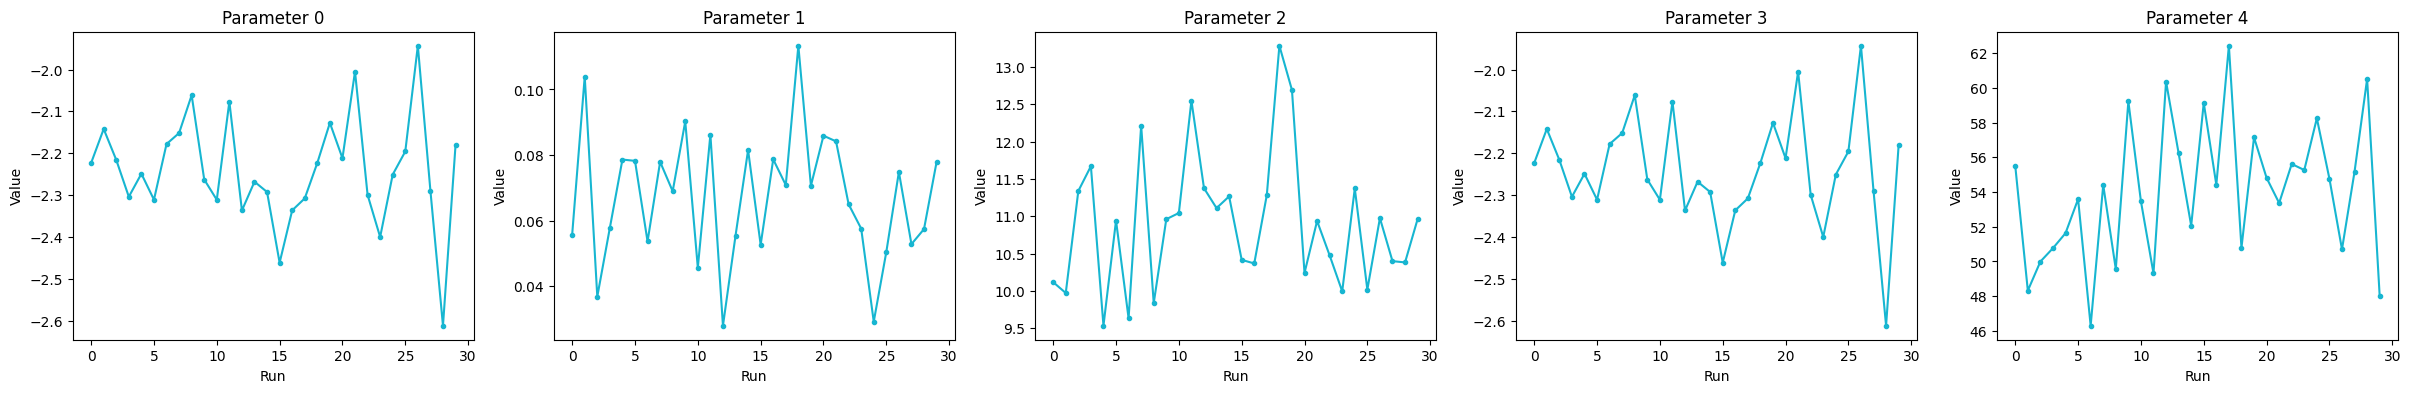

In [84]:
plot_params_iterations2(all_param_sets)

---

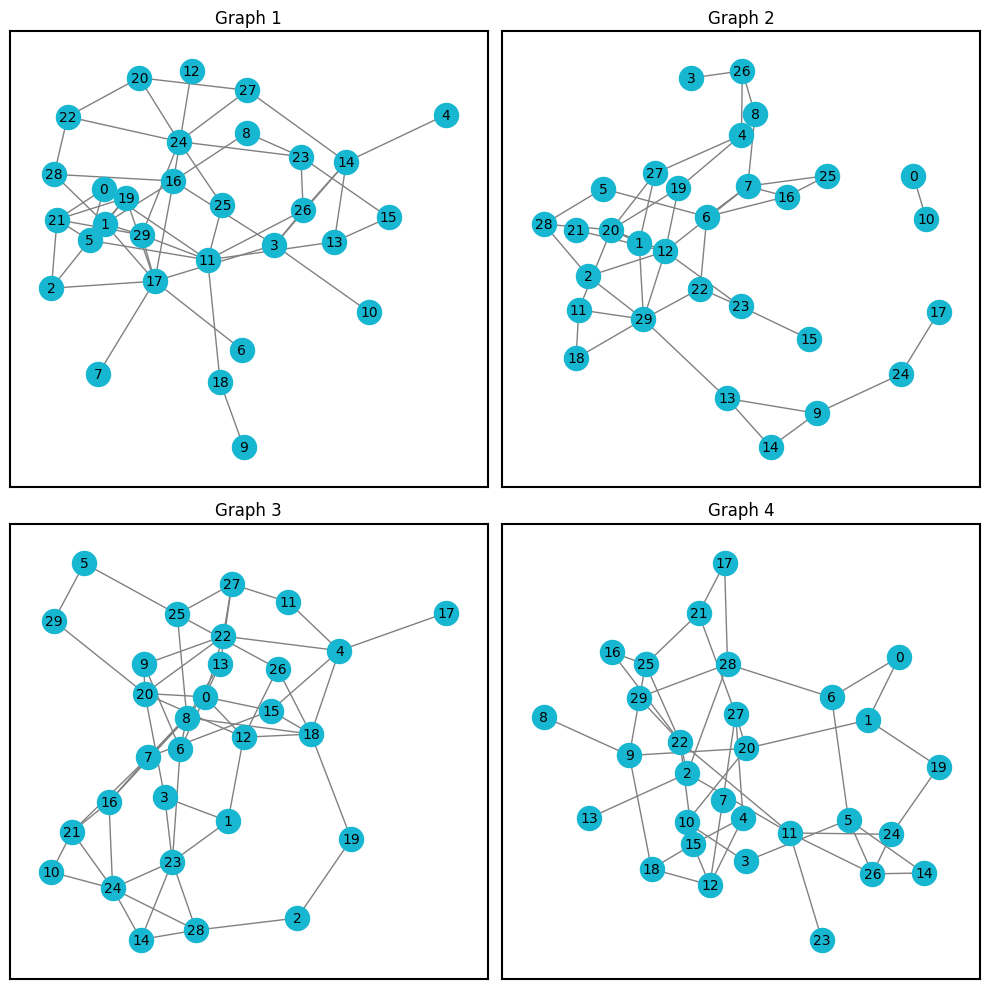

In [230]:
plot_random_graphs(graphs_five_stats, n=4, labels=True, nodecolor='#17B6D1', layout="spring")